In [1]:
import os
import sys
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/notebooks/reports/"))
import util
import motif.read_motifs as read_motifs
import plot.viz_sequence as viz_sequence
import h5py
import numpy as np
import matplotlib.pyplot as plt

### Define constants and paths

In [2]:
out_path = "/users/amtseng/tfmodisco/figures/ZNF248_pwm_vs_cwm"
os.makedirs(out_path, exist_ok=True)

In [3]:
tfm_motifs_path = os.path.join(
    "/users/amtseng/tfmodisco/results/reports/tfmodisco_results/cache/",
    "ZNF248",
    "ZNF248_ChIPexo",
    "ZNF248_ChIPexo_count",
    "all_motifs.h5"
)

homer25_motifs_path = "/users/amtseng/tfmodisco/results/classic_motifs/peaks/ZNF248/ZNF248_ChIPExo/homer_25"
homer50_motifs_path = "/users/amtseng/tfmodisco/results/classic_motifs/peaks/ZNF248/ZNF248_ChIPExo/homer_50"
meme_motifs_path = "/users/amtseng/tfmodisco/results/classic_motifs/peaks/ZNF248/ZNF248_ChIPExo/memechip/meme_out"

b1h_motif_path = "/users/amtseng/tfmodisco/data/processed/B1H/ZNF248_B1Hcode.txt"

### PWM vs CWM vs B1H

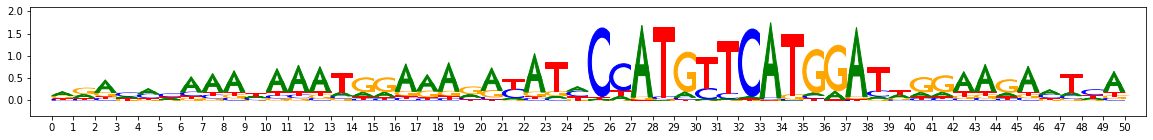

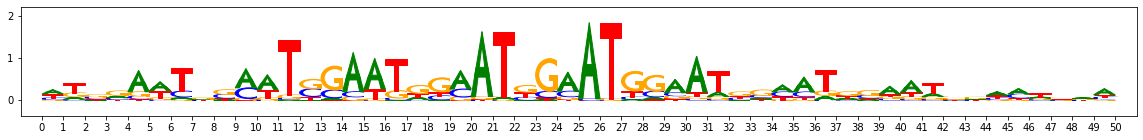

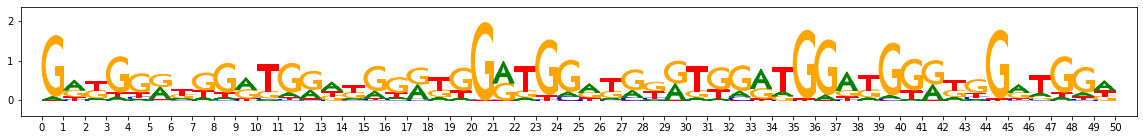

In [4]:
# Import and show TF-MoDISco motifs
with h5py.File(tfm_motifs_path, "r") as f:
    tfm_pfms, tfm_cwms = {}, {}
    tfm_motif_keys = []
    for key in f.keys():
        tfm_pfms[key] = f[key]["pfm_trimmed"][:]
        tfm_cwms[key] = f[key]["cwm_trimmed"][:]
        if not np.all(tfm_pfms[key] == util.purine_rich_motif(tfm_pfms[key])):
            tfm_pfms[key] = util.purine_rich_motif(tfm_pfms[key])
            tfm_cwms[key] = util.purine_rich_motif(tfm_cwms[key])
        tfm_motif_keys.append(key)
        
for key in tfm_motif_keys:
    viz_sequence.plot_weights(read_motifs.pfm_to_pwm(tfm_pfms[key]))

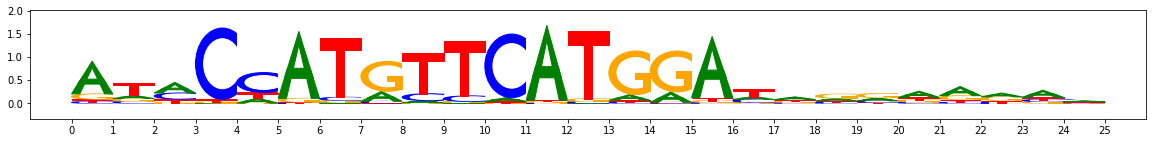

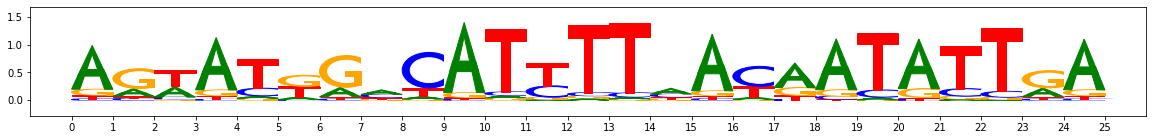

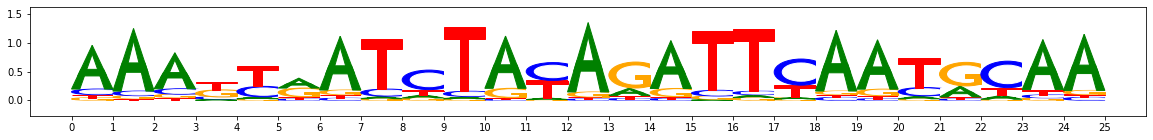

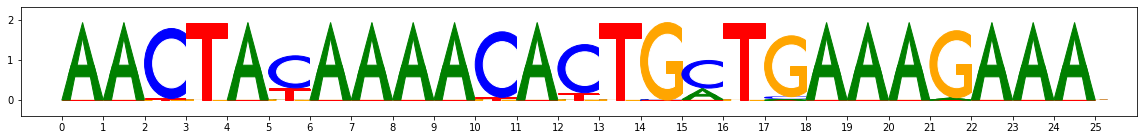

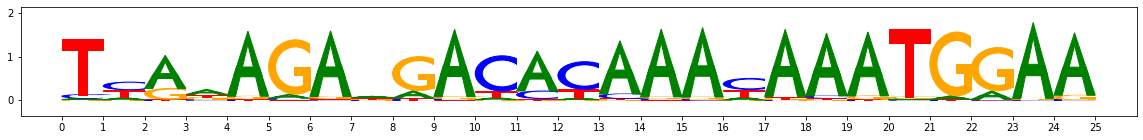

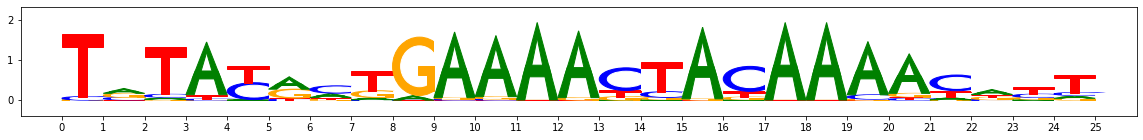

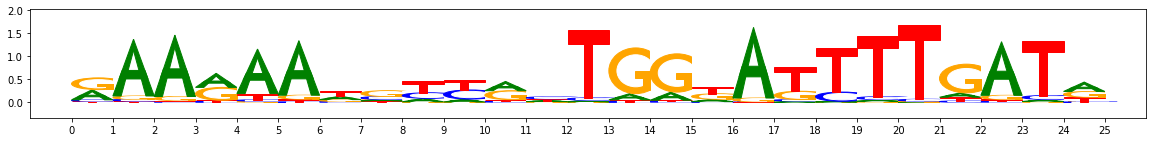

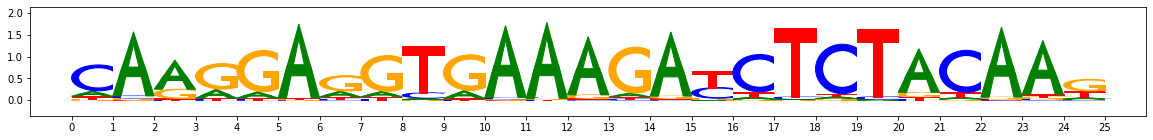

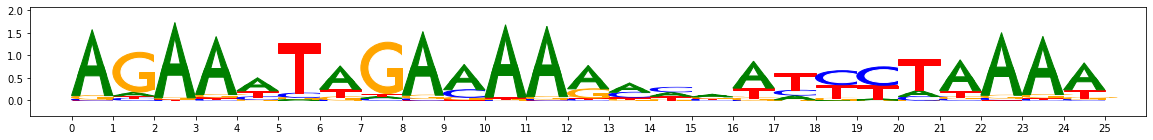

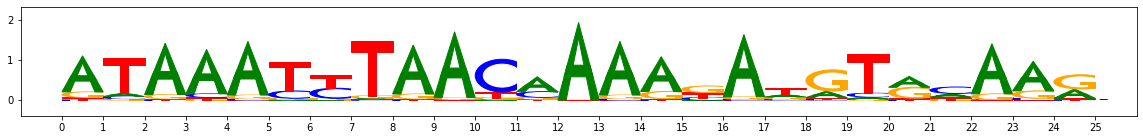

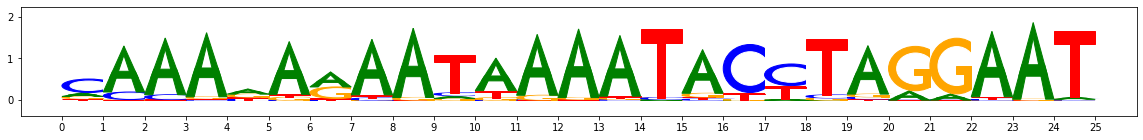

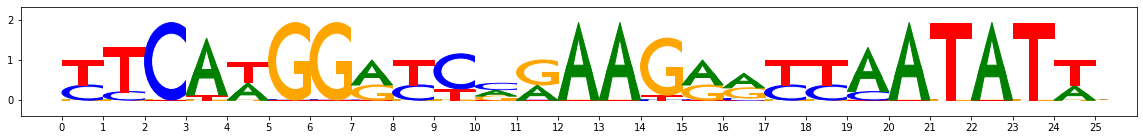

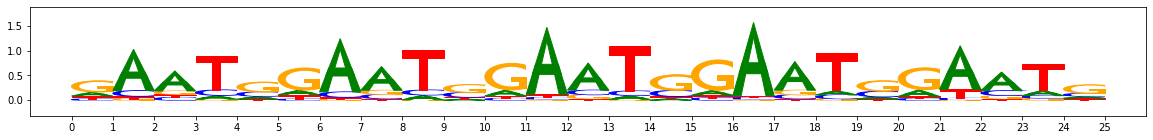

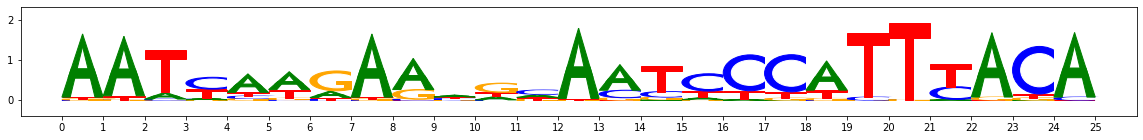

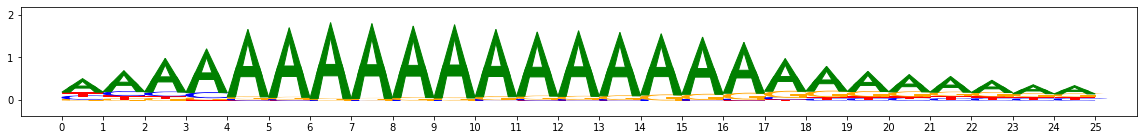

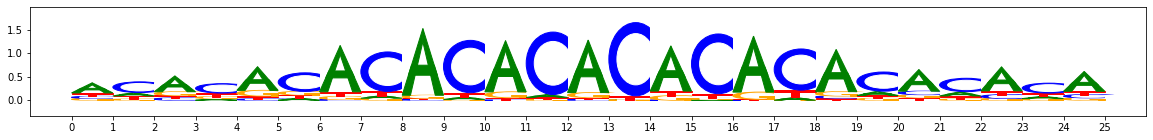

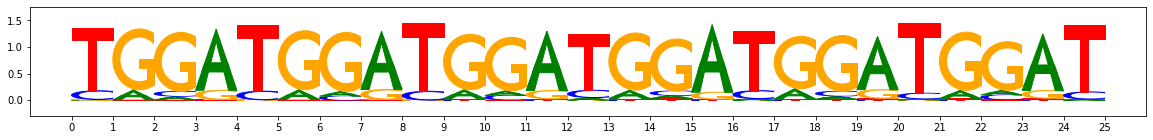

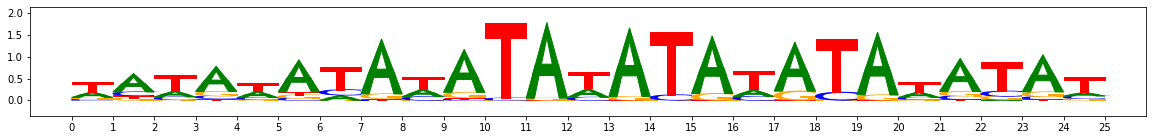

In [5]:
# Import and show HOMER 25 motifs
homer25_pfms = [util.purine_rich_motif(pfm) for pfm in read_motifs.import_homer_pfms(homer25_motifs_path)[0]]

for pfm in homer25_pfms:
    viz_sequence.plot_weights(read_motifs.pfm_to_pwm(pfm))

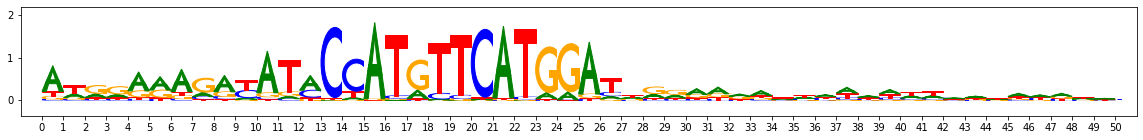

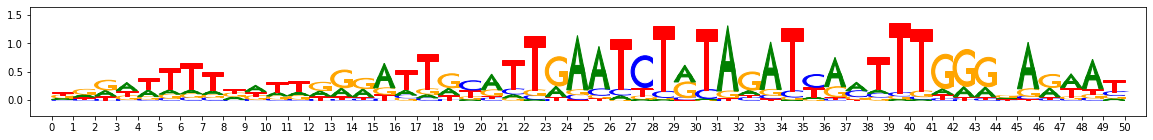

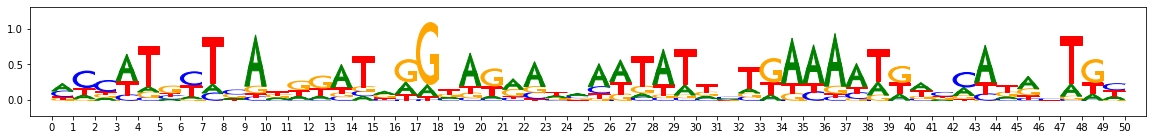

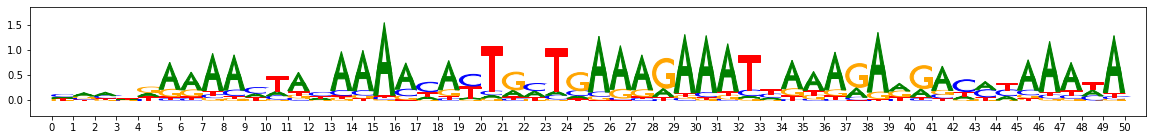

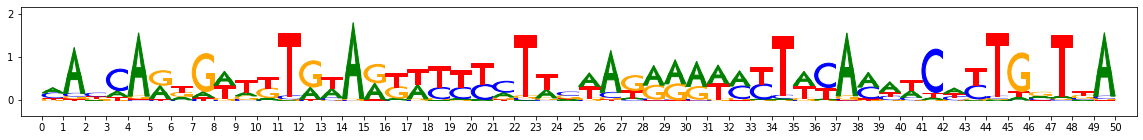

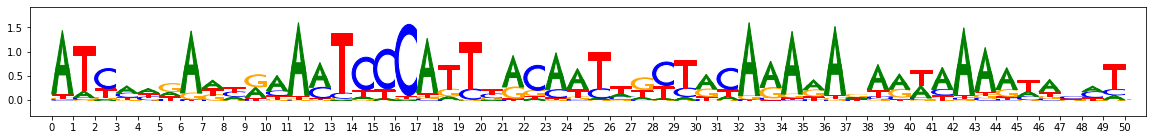

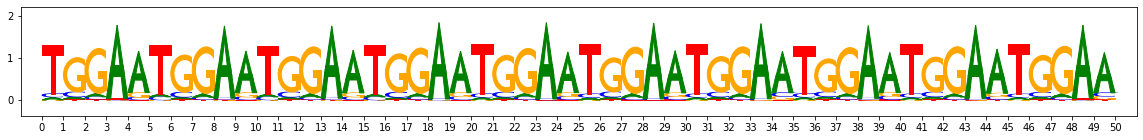

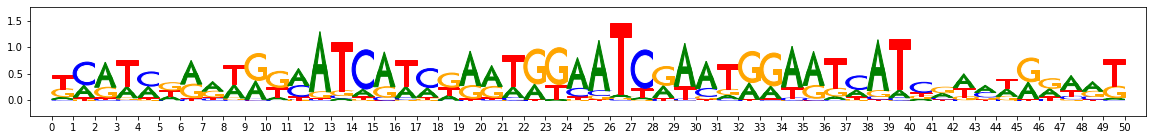

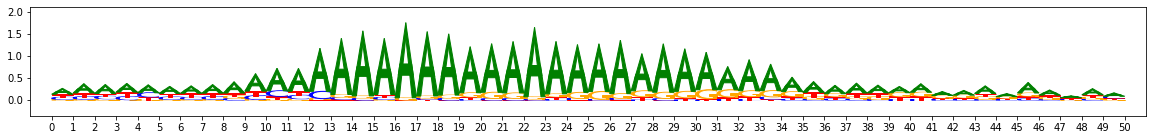

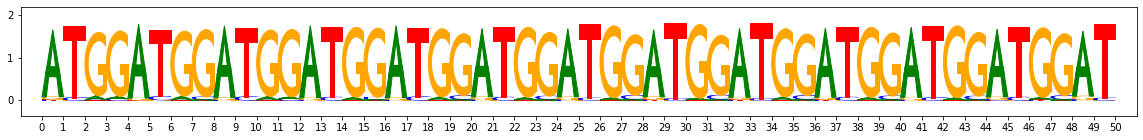

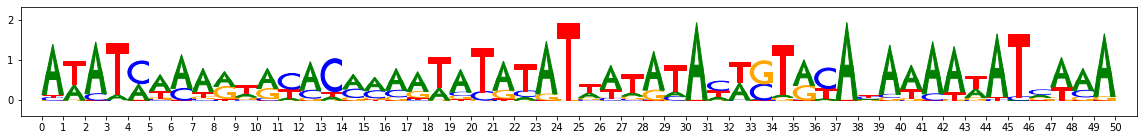

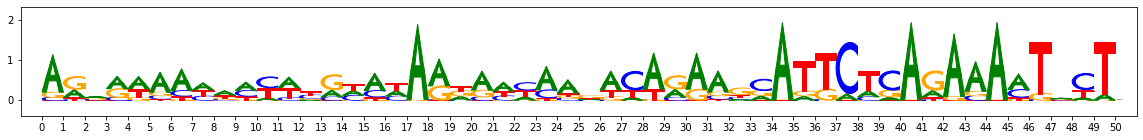

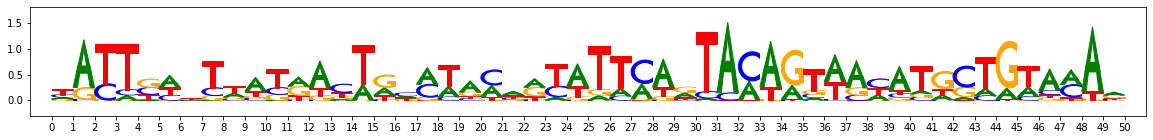

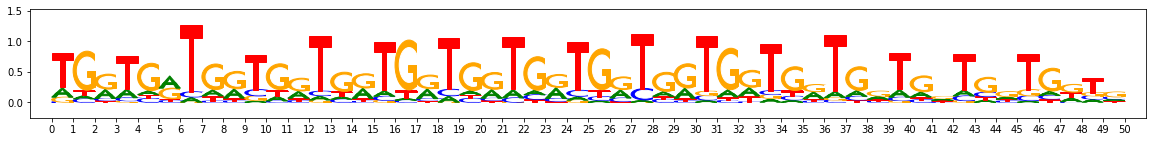

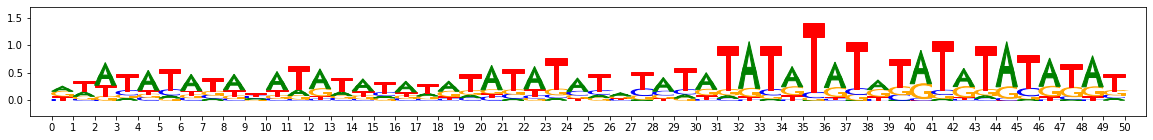

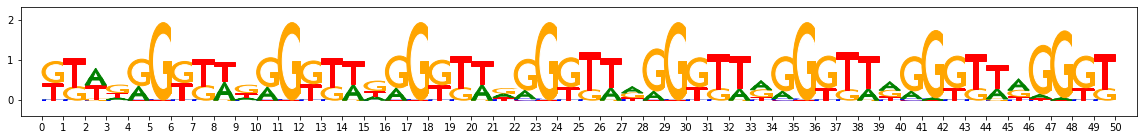

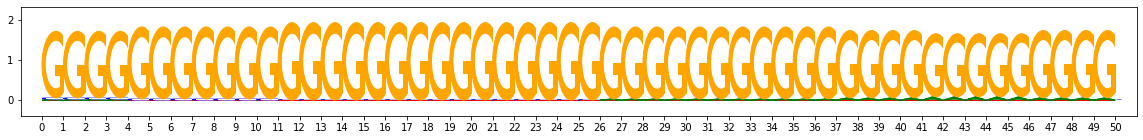

In [6]:
# Import and show HOMER 50 motifs
homer50_pfms = [util.purine_rich_motif(pfm) for pfm in read_motifs.import_homer_pfms(homer50_motifs_path)[0]]

for pfm in homer50_pfms:
    viz_sequence.plot_weights(read_motifs.pfm_to_pwm(pfm))

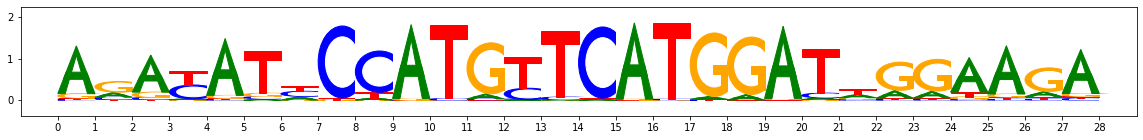

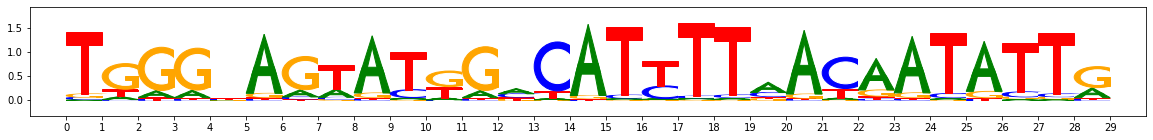

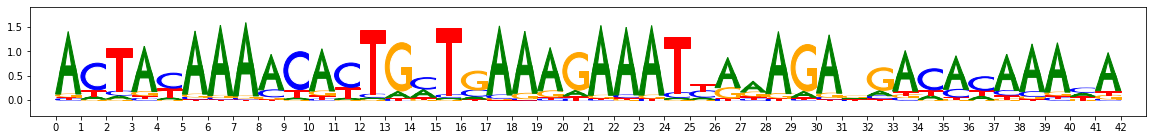

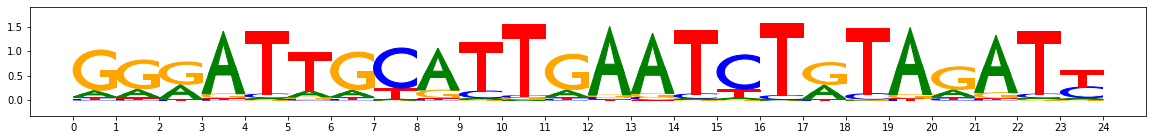

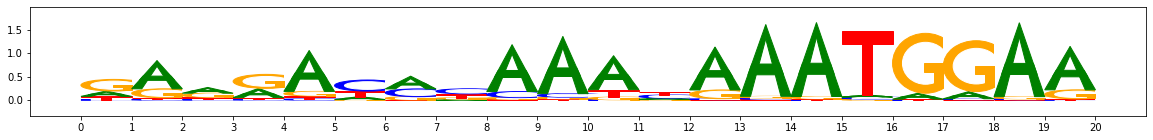

In [7]:
# Import and show MEME motifs
meme_pfms = [util.purine_rich_motif(pfm) for pfm in read_motifs.import_meme_pfms(meme_motifs_path)[0]]

for pfm in meme_pfms:
    viz_sequence.plot_weights(read_motifs.pfm_to_pwm(pfm))

In [8]:
# Import B1H recognition code
with open(b1h_motif_path, "r") as f:
    line = next(f)
    while not line.startswith("Pos"):
        line = next(f)
    rows = []
    for line in f:
        tokens = line.strip().split("\t")[1:]
        if len(tokens) != 4:
            continue
        rows.append(np.array([float(x) for x in tokens]))
b1h_code = np.stack(rows)

In [9]:
# Align the B1H recognition to the TF-MoDISco motifs
b1h_code_aligned = np.zeros((50, 4))
b1h_code_aligned[20 : 20 + 21] = b1h_code

In [10]:
# Align the benchmark motifs to the TF-MoDISco motifs
homer25_aligned = np.zeros((50, 4))
homer25_aligned[22:22 + 25] = homer25_pfms[0]

homer50_aligned = np.zeros((50, 4))
homer50_aligned[12:] = homer50_pfms[0][:50 - 12]

meme_aligned = np.zeros((50, 4))
meme_aligned[18:18 + len(meme_pfms[0])] = meme_pfms[0]

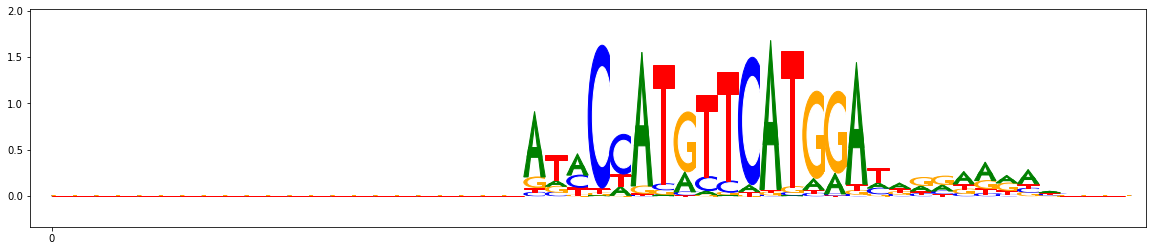

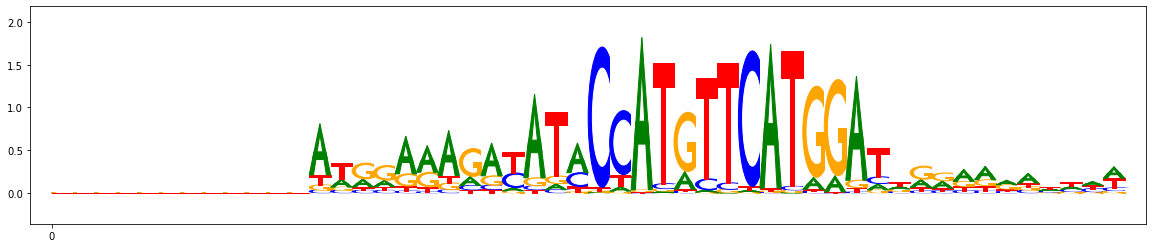

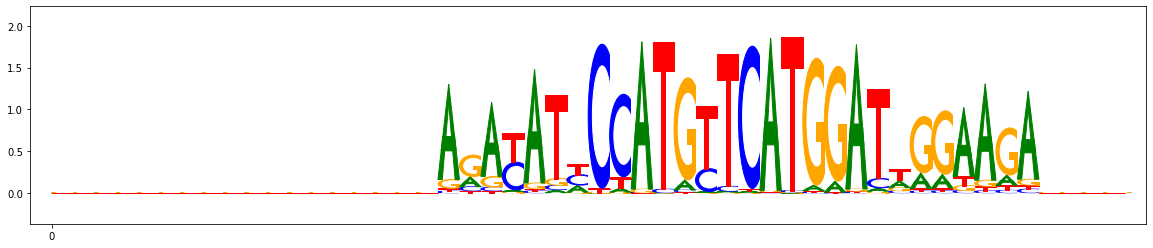

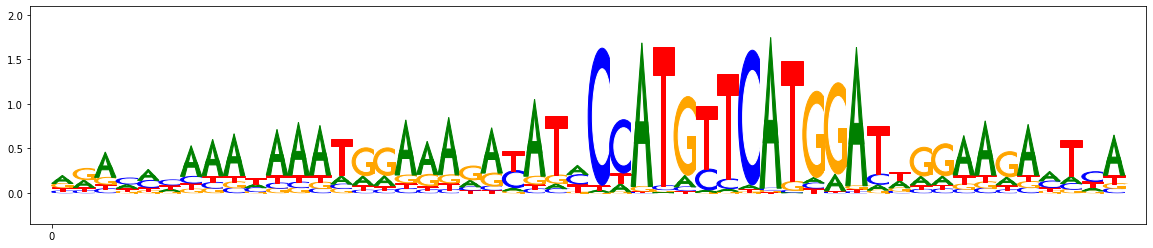

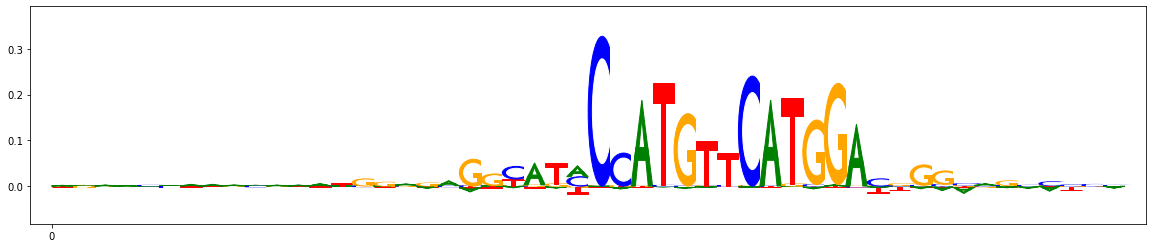

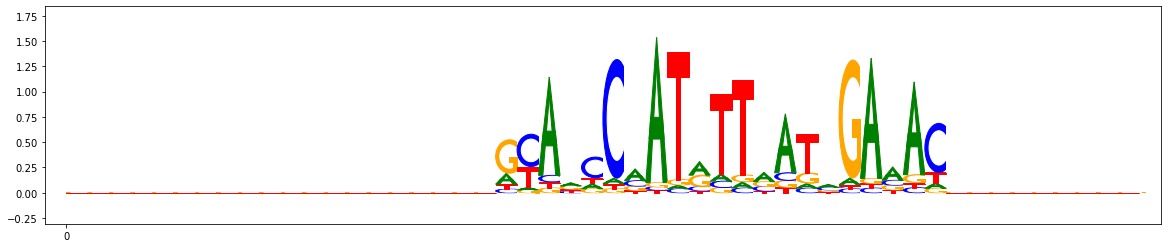

In [11]:
viz_sequence.plot_weights(read_motifs.pfm_to_pwm(homer25_aligned), subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "ZNF248_homer25_pwm.svg"),
    format="svg"
)

viz_sequence.plot_weights(read_motifs.pfm_to_pwm(homer50_aligned), subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "ZNF248_homer50_pwm.svg"),
    format="svg"
)

viz_sequence.plot_weights(read_motifs.pfm_to_pwm(meme_aligned), subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "ZNF248_meme_pwm.svg"),
    format="svg"
)

viz_sequence.plot_weights(read_motifs.pfm_to_pwm(tfm_pfms["0_0"]), subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "ZNF248_tfm_pwm.svg"),
    format="svg"
)
viz_sequence.plot_weights(tfm_cwms["0_0"], subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "ZNF248_tfm_cwm.svg"),
    format="svg"
)

viz_sequence.plot_weights(read_motifs.pfm_to_pwm(b1h_code_aligned), subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "ZNF248_B1H.svg"),
    format="svg"
)